# Co-author Network Link Prediction - Tuning node2vec model

Data comes from https://www.aminer.org/citation

Based on "Graphs and Machine Learning in Practice: Link Prediction" in Graph Algorithms. Practical Examples in Apache Spark and Neo4j.



In [3]:
import pandas as pd

In [4]:
import json
from py2neo import  Graph, Node
import os

## The Coauthorship Graph

https://neo4j.com/blog/cypher-load-json-from-url/

In [5]:
# create a graph
graphdb = Graph(scheme="bolt", host="localhost", port=7687, secure=False, auth=('neo4j', 'test'))
#graphdb.delete_all()

## Spark

In [6]:
import findspark
findspark.init()

In [7]:
import pyspark
sc = pyspark.SparkContext(appName="link_prediction")

In [8]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master("local") \
    .appName("link_prediction") \
    .getOrCreate()


In [9]:
test_df=pd.read_csv("data/testdf.csv")
training_df=pd.read_csv("data/trainingdf.csv")

In [10]:
training_data=spark.createDataFrame(training_df)

In [11]:
training_data.show(n=5)

+-----+-----+-----+
|node1|node2|label|
+-----+-----+-----+
|  268|  786|    1|
| 3493| 3493|    0|
| 1999| 2000|    1|
| 3563| 3563|    0|
| 3586| 3586|    0|
+-----+-----+-----+
only showing top 5 rows



In [12]:
training_data.groupby("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    0| 2400|
|    1| 2400|
+-----+-----+



In [13]:
test_data=spark.createDataFrame(test_df)

In [14]:
test_data.groupby("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    0| 3243|
|    1| 3243|
+-----+-----+



In [16]:
# create a graph projection
graphdb.run("""CALL gds.graph.create('early_graph',
    'Author', 
    {
        CO_AUTHOR_EARLY: {
                type: 'CO_AUTHOR_EARLY',
                orientation: 'UNDIRECTED'
                }
                }
                )""")

In [78]:
graphdb.run("""CALL gds.graph.list""").evaluate()

'early_graph'

In [269]:
# create a graph projection
graphdb.run("""CALL gds.graph.create('late_graph',
    'Author', 
    {
        CO_AUTHOR: {
                type: 'CO_AUTHOR',
                orientation: 'UNDIRECTED'
                }
                }
                )""")

# Node2Vec Graph Embeddings 

https://towardsdatascience.com/node-embeddings-node2vec-with-neo4j-5152d3472d8e

Neo4j Graph Data Science library supports the random walk algorithm, which makes it very easy for us to implement the node2vec algorithm.

We will start by projecting the in-memory graph. We describe all three node labels and project relationships as undirected.

Now we are ready to train our first node2vec model. The process will consist of three parts:

    Execute the random walk algorithm starting from each node in the graph
    Feed the random walks to word2vec algorithm
    Inspect results by looking at the most similar neighbors

The random walk algorithm has an optional start parameter, which can be used to define the starting node of the walk. We can also specify how long the walk should be with the steps setting and how many times it should be repeated with the walks parameter. Note that every time random walk is executed, we expect a different result.

We will use the Word2vec algorithm implementation in the gensim library. It also has a couple of hyperparameters we can define. Most notable are:

    size: Dimensionality of the embedding vectors
    window: Maximum distance between the current and predicted word
    min_count: The minimum count of words to consider when training the model; words with occurrence less than this count will be ignored.
    sg: The training algorithm: 1 for skip-gram; otherwise default CBOW
   
https://towardsdatascience.com/node2vec-embeddings-for-graph-data-32a866340fef
    
Node2vec’s sampling strategy, accepts 4 arguments:
— Number of walks: Number of random walks to be generated from each node in the graph
— Walk length: How many nodes are in each random walk
— P: Return hyperparameter
— Q: Inout hyperaprameter
and also the standard skip-gram parameters (context window size, number of iterations etc.)

The algorithm for the random walk generation will go over each node in the graph and will generate <number of walks> random walks, of length <walk length>.
    
           
https://neo4j.com/docs/graph-data-science/current/alpha-algorithms/random-walk/


https://cs.stanford.edu/~jure/pubs/node2vec-kdd16.pdf


http://snap.stanford.edu/node2vec/
    
    
https://stellargraph.readthedocs.io/en/stable/demos/link-prediction/node2vec-link-prediction.html

Node2Vec first involves running random walks on the graph to obtain our context pairs, and using these to train a Word2Vec model.



https://radimrehurek.com/gensim/models/word2vec.html


https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html#sphx-glr-auto-examples-tutorials-run-word2vec-py



There are actually alpha implementations of node embeddings in Neo4j. Alpha designation indicates that the algorithm is experimental and might be changed or removed at any time.

https://neo4j.com/docs/graph-data-science/current/algorithms/node-embeddings/

We use Node2Vec [1], to calculate node embeddings. These embeddings are learned in such a way to ensure that nodes that are close in the graph remain close in the embedding space. Node2Vec first involves running random walks on the graph to obtain our context pairs, and using these to train a Word2Vec model.

These are the set of parameters we can use:
 
    p - Random walk parameter “p”
    q - Random walk parameter “q”
    dimensions - Dimensionality of node2vec embeddings
    num_walks - Number of walks from each node
    walk_length - Length of each random walk
    window_size - Context window size for Word2Vec
    num_iter - number of SGD iterations (epochs)
    workers - Number of workers for Word2Vec
    
The Word2Vec Skip-gram model, for example, takes in pairs (word1, word2) generated by moving a window across text data, and trains a 1-hidden-layer neural network based on the synthetic task of given an input word, giving us a predicted probability distribution of nearby words to the input. A virtual one-hot encoding of words goes through a ‘projection layer’ to the hidden layer; these projection weights are later interpreted as the word embeddings. So if the hidden layer has 300 neurons, this network will give us 300-dimensional word embeddings.
    

In [ ]:
# for some reason doesnt have this algorithm
# graphdb.run("""CALL gds.alpha.node2vec.stream('early_graph', {dimensions: 2})""")

In [250]:
import gensim.models
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.types import StructField, StructType,IntegerType

def apply_node2vec_features(data, graph_name, steps, walks, size, window, output_col_name):
    
    params = {
    "pairs": [{"node1": row["node1"], "node2": row["node2"]}
    for row in data.collect()],
    "steps": steps,
    "walks": walks,
    "size": size,
    "graph_name": graph_name
    }

    query=("""
    UNWIND $pairs as pair
    MATCH (p:Author) WHERE id(p) = pair.node1 OR id(p) = pair.node2
    WITH DISTINCT p
    CALL gds.alpha.randomWalk.stream($graph_name,{
        start: id(p),
        steps: $steps,
        walks: $walks
    })
    YIELD nodeIds
    RETURN [id in nodeIds | toString(id)] as walks
    """)

    random_walks=graphdb.run(query, params).to_series()
    
    model=gensim.models.Word2Vec(random_walks, sg=1, window=window, size=size, min_count=1)

    vectors=[{"node1":row["node1"],
            "node2": row["node2"],
            output_col_name:Vectors.dense(list(model.wv[str(row["node1"])]) + 
                       list(model.wv[str(row["node2"])]))} for row in data.collect()]
    
    schema = StructType([
        StructField('node1', IntegerType()),
        StructField('node2', IntegerType()),
        StructField(output_col_name, VectorUDT())])

    features=spark.createDataFrame(vectors, schema)
    return data.join(features, ["node1", "node2"])

In [348]:
training_data = apply_node2vec_features(training_data, 'early_graph', 3, 1, 3, 5, "model_3steps")


In [253]:
# steps=5,10
# walks=1
# size=3
# window=5

training_data = apply_node2vec_features(training_data, 'early_graph', 5, 1, 3, 5, "model_5steps")
training_data = apply_node2vec_features(training_data, 'early_graph', 10, 1, 3, 5, "model_10steps")

In [321]:
training_data = apply_node2vec_features(training_data, 'early_graph', 5, 3, 3, 5, "model_5steps3walks")

In [335]:
training_data = apply_node2vec_features(training_data, 'early_graph', 80, 10, 128, 10, "neo4j_defaults")

In [336]:
training_data.show(n=3)

+-----+-----+-----+--------------------+--------------------+----+----+--------------------+--------------------+
|node1|node2|label|        model_5steps|       model_10steps|fold|test|  model_5steps3walks|      neo4j_defaults|
+-----+-----+-----+--------------------+--------------------+----+----+--------------------+--------------------+
|   22|   25|    1|[0.09874928742647...|[1.20070803165435...|   0|   0|[-0.1850879639387...|[1.36831581592559...|
|  412| 2326|    0|[-0.0149135589599...|[0.77401143312454...|   0|   0|[-0.6980580687522...|[1.13592541217803...|
|  648|  651|    1|[-0.1056197658181...|[0.95529681444168...|   0|   0|[-0.6156281828880...|[1.37412452697753...|
+-----+-----+-----+--------------------+--------------------+----+----+--------------------+--------------------+
only showing top 3 rows



In [347]:
test_data = apply_node2vec_features(test_data, 'late_graph', 3, 1, 3, 5, "model_3steps")


In [270]:
test_data = apply_node2vec_features(test_data, 'late_graph', 5, 1, 3, 5, "model_5steps")
test_data = apply_node2vec_features(test_data, 'late_graph', 10, 1, 3, 5, "model_10steps")

In [323]:
test_data = apply_node2vec_features(test_data, 'late_graph', 5, 3, 3, 5, "model_5steps3walks")

In [337]:
test_data = apply_node2vec_features(test_data, 'late_graph', 80, 10, 128, 10, "neo4j_defaults")

In [338]:
test_data.show(n=3)

+-----+-----+-----+--------------------+--------------------+----+----+--------------------+--------------------+
|node1|node2|label|        model_5steps|       model_10steps|fold|test|  model_5steps3walks|      neo4j_defaults|
+-----+-----+-----+--------------------+--------------------+----+----+--------------------+--------------------+
|    8| 4958|    1|[0.24589589238166...|[1.29405760765075...|   0|   1|[1.89659512042999...|[0.84257227182388...|
|   61|   63|    1|[0.10539633035659...|[0.47493508458137...|   0|   1|[0.76353633403778...|[0.74830365180969...|
|  435|  435|    0|[0.05750015005469...|[0.74363851547241...|   0|   1|[0.69708830118179...|[0.19481378793716...|
+-----+-----+-----+--------------------+--------------------+----+----+--------------------+--------------------+
only showing top 3 rows



In [259]:
from pyspark.ml.feature import RFormula

rForm = RFormula()

from pyspark.ml.tuning import ParamGridBuilder
params = ParamGridBuilder()\
    .addGrid(rForm.formula, [
    "label ~ model_5steps",
    "label ~ model_10steps"])\
    .build()

params

[{Param(parent='RFormula_2e7ce8c05c7e', name='formula', doc='R model formula'): 'label ~ model_5steps'},
 {Param(parent='RFormula_2e7ce8c05c7e', name='formula', doc='R model formula'): 'label ~ model_10steps'}]

In [324]:
from pyspark.ml.tuning import ParamGridBuilder
params2 = ParamGridBuilder()\
    .addGrid(rForm.formula, [
    "label ~ model_5steps3walks"])\
    .build()


In [339]:
from pyspark.ml.tuning import ParamGridBuilder
params3 = ParamGridBuilder()\
    .addGrid(rForm.formula, [
    "label ~ neo4j_defaults"])\
    .build()


In [349]:
from pyspark.ml.tuning import ParamGridBuilder
params4 = ParamGridBuilder()\
    .addGrid(rForm.formula, [
    "label ~ model_3steps"])\
    .build()


In [260]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline

rf = RandomForestClassifier(labelCol="label", 
        featuresCol="features",
        numTrees=30, maxDepth=10)

stages=[rForm, rf]
pipeline=Pipeline().setStages(stages)

In [261]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()\
    .setMetricName("areaUnderROC")\
    .setRawPredictionCol("prediction")\
    .setLabelCol("label")

In [262]:
import mycrossvalidator as mycv
from importlib import reload  
reload(mycv)

<module 'mycrossvalidator' from '/home/areias/Documents/DataScience/graphs/mycrossvalidator.py'>

In [297]:
cv = mycv.MyCrossValidator(parallelism=2)\
    .setEstimator(pipeline)\
    .setEvaluator(evaluator)\
    .setEstimatorParamMaps(params)\
    .setCollectSubModels(True)


In [298]:
training_data.show(n=5)

+-----+-----+-----+--------------------+--------------------+----+----+
|node1|node2|label|        model_5steps|       model_10steps|fold|test|
+-----+-----+-----+--------------------+--------------------+----+----+
|   22|   25|    1|[0.09874928742647...|[1.20070803165435...|   0|   0|
|  412| 2326|    0|[-0.0149135589599...|[0.77401143312454...|   0|   0|
|  648|  651|    1|[-0.1056197658181...|[0.95529681444168...|   0|   0|
|  753|  753|    0|[-0.0503539331257...|[0.98245859146118...|   0|   0|
| 1045| 4807|    0|[0.02308512665331...|[1.27879261970520...|   0|   0|
+-----+-----+-----+--------------------+--------------------+----+----+
only showing top 5 rows



In [265]:
from pyspark.sql.functions import lit
training_data=training_data.withColumn("fold",lit(0))

In [266]:
training_data=training_data.withColumn("test",lit(0))

In [267]:
training_data.show(n=5)

+-----+-----+-----+--------------------+--------------------+----+----+
|node1|node2|label|        model_5steps|       model_10steps|fold|test|
+-----+-----+-----+--------------------+--------------------+----+----+
|   22|   25|    1|[0.09874928742647...|[1.20070803165435...|   0|   0|
|  412| 2326|    0|[-0.0149135589599...|[0.77401143312454...|   0|   0|
|  648|  651|    1|[-0.1056197658181...|[0.95529681444168...|   0|   0|
|  753|  753|    0|[-0.0503539331257...|[0.98245859146118...|   0|   0|
| 1045| 4807|    0|[0.02308512665331...|[1.27879261970520...|   0|   0|
+-----+-----+-----+--------------------+--------------------+----+----+
only showing top 5 rows



In [272]:
test_data=test_data.withColumn("fold",lit(0))
test_data=test_data.withColumn("test",lit(1))

In [329]:
test_data.show(n=3)

+-----+-----+-----+--------------------+--------------------+----+----+--------------------+
|node1|node2|label|        model_5steps|       model_10steps|fold|test|  model_5steps3walks|
+-----+-----+-----+--------------------+--------------------+----+----+--------------------+
|    8| 4958|    1|[0.24589589238166...|[1.29405760765075...|   0|   1|[1.89659512042999...|
|   61|   63|    1|[0.10539633035659...|[0.47493508458137...|   0|   1|[0.76353633403778...|
|  435|  435|    0|[0.05750015005469...|[0.74363851547241...|   0|   1|[0.69708830118179...|
+-----+-----+-----+--------------------+--------------------+----+----+--------------------+
only showing top 3 rows



In [350]:
all_df=training_data.union(test_data)

In [341]:
all_df.show(n=5)

+-----+-----+-----+--------------------+--------------------+----+----+--------------------+--------------------+
|node1|node2|label|        model_5steps|       model_10steps|fold|test|  model_5steps3walks|      neo4j_defaults|
+-----+-----+-----+--------------------+--------------------+----+----+--------------------+--------------------+
|   22|   25|    1|[0.09874928742647...|[1.20070803165435...|   0|   0|[-0.1850879639387...|[1.36831581592559...|
|  412| 2326|    0|[-0.0149135589599...|[0.77401143312454...|   0|   0|[-0.6980580687522...|[1.13592541217803...|
|  648|  651|    1|[-0.1056197658181...|[0.95529681444168...|   0|   0|[-0.6156281828880...|[1.37412452697753...|
|  753|  753|    0|[-0.0503539331257...|[0.98245859146118...|   0|   0|[-0.1417549401521...|[1.21684145927429...|
| 1045| 4807|    0|[0.02308512665331...|[1.27879261970520...|   0|   0|[-0.8098255395889...|[0.42895343899726...|
+-----+-----+-----+--------------------+--------------------+----+----+-----------------

In [299]:
mycvfitted, foldstats = cv.fit(all_df)

In [300]:
mycvfitted.avgMetrics

[0.6356768424298489, 0.5282146160962072]

In [278]:
foldstats

[[0.6356768424298489], [0.5282146160962072]]

In [325]:
cv2 = mycv.MyCrossValidator(parallelism=2)\
    .setEstimator(pipeline)\
    .setEvaluator(evaluator)\
    .setEstimatorParamMaps(params2)\
    .setCollectSubModels(True)


In [342]:
cv3 = mycv.MyCrossValidator(parallelism=2)\
    .setEstimator(pipeline)\
    .setEvaluator(evaluator)\
    .setEstimatorParamMaps(params3)\
    .setCollectSubModels(True)

In [351]:
cv4 = mycv.MyCrossValidator(parallelism=2)\
    .setEstimator(pipeline)\
    .setEvaluator(evaluator)\
    .setEstimatorParamMaps(params4)\
    .setCollectSubModels(True)

In [330]:
mycvfitted2, foldstats2 = cv2.fit(all_df)

In [332]:
mycvfitted2.avgMetrics

[0.49984582176996606]

In [343]:
mycvfitted3, foldstats3 = cv3.fit(all_df)

In [352]:
mycvfitted4, foldstats4 = cv4.fit(all_df)

In [317]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt  
%matplotlib inline

def get_roc_curve(model,test_data):
    
    predictions=model.transform(test_data)
    
    preds = predictions.select('label','probability')\
    .rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))\
    .collect()
     
    y_score, y_true = zip(*preds)
    fpr, tpr, thresholds = roc_curve(y_true, y_score, pos_label = 1)
    
    return fpr,tpr,thresholds

In [319]:
fpr10,tpr10,thresholds10 = get_roc_curve(mycvfitted.subModels[0][1], test_data)

In [333]:
fpr53,tpr53,thresholds53 = get_roc_curve(mycvfitted2.subModels[0][0], test_data)

In [344]:
fpr_neo4j,tpr_neo4j,thresholds_neo4j = get_roc_curve(mycvfitted3.subModels[0][0], test_data)

In [353]:
fpr_3,tpr_3,thresholds_3 = get_roc_curve(mycvfitted4.subModels[0][0], test_data)

In [312]:
from cycler import cycler
def create_roc_plot():
    plt.style.use('classic')
    fig = plt.figure(figsize=(13, 8))
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.rc('axes', prop_cycle=(cycler('color',
    ['r', 'g', 'b', 'c', 'm', 'y', 'k'])))
    plt.plot([0, 1], [0, 1], linestyle='--', label='Random score (AUC = 0.50)')
    return plt, fig

def add_curve(plt, title, fpr, tpr, roc):
    plt.plot(fpr, tpr, label=f"{title} (AUC = {roc:0.2})")
    

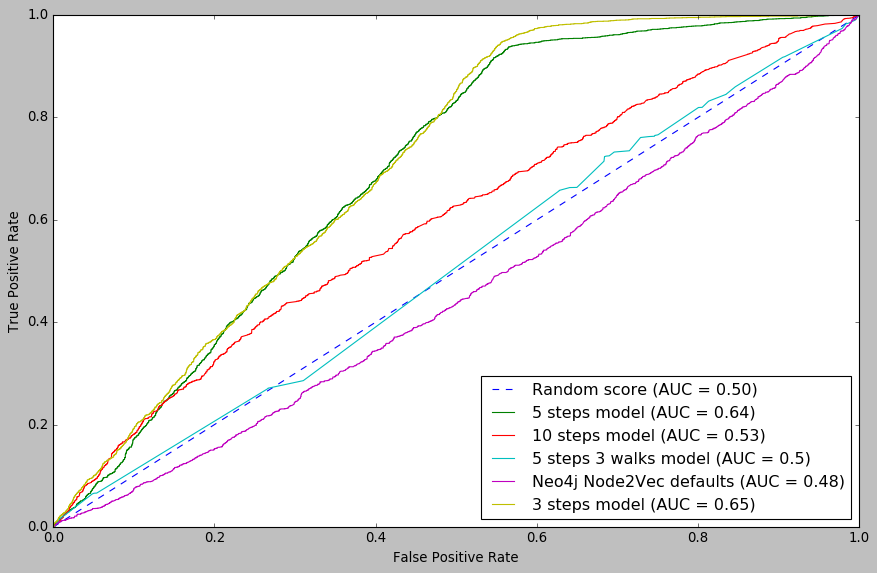

In [354]:
plt,fig = create_roc_plot()

add_curve(plt, "5 steps model",
    fpr, tpr,
    mycvfitted.avgMetrics[0])

add_curve(plt, "10 steps model",
    fpr10, tpr10,
    mycvfitted.avgMetrics[1])

add_curve(plt, "5 steps 3 walks model",
    fpr53, tpr53,
    mycvfitted2.avgMetrics[0])

add_curve(plt, "Neo4j Node2Vec defaults",
    fpr_neo4j, tpr_neo4j,
    mycvfitted3.avgMetrics[0])

add_curve(plt, "3 steps model",
    fpr_3, tpr_3,
    mycvfitted4.avgMetrics[0])

plt.legend(loc='lower right')
plt.show()